# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random

import tqdm
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector 

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from sklearn import svm
from pyod.models.mcd import MCD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.abod import ABOD
from alibi_detect.od import IForest
from pyod.models.hbos import HBOS
from pyod.models.sos import SOS
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.lscp import LSCP
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Class Code

In [2]:
class Conf_matrx:
    def __init__(self,original,compare):
        self.original = original
        self.compare = compare
    def conf(self,name):
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        print('Accuracy: %.3f' % self.acc)
        print('Precision: %.3f' % self.pre)
        print('Recall: %.3f' % self.rec)
        print('F1 Score: %.3f' % self.f1)

In [3]:
class Linear:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=20): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [4]:
class Orbit:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=20): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [5]:
class BUNNY:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

## Linear

In [6]:
np.random.seed(3)
epsilon = np.around(np.random.normal(size=1000),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, 25).round(15), np.random.uniform(5, 7, 25).round(15), np.repeat(0, 950))), 1000)
eta = signal + epsilon

In [7]:
outlier_true_one_1 = signal.copy()

In [8]:
outlier_true_one_1 = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one_1))

In [9]:
x_1 = np.linspace(0,2,1000)
y1_1 = 5 * x_1
y_1 = y1_1 + eta # eta = signal + epsilon

In [10]:
_df=pd.DataFrame({'x':x_1, 'y':y_1})

### GODE

In [11]:
w=np.zeros((1000,1000))

In [12]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [13]:
_Linear = Linear(_df)

In [14]:
_Linear.fit(sd=20)

In [15]:
outlier_simul_one = (_Linear.df['Residual']**2).tolist()

In [16]:
outlier_simul_one = list(map(lambda x: -1 if x > 13.3 else 1,outlier_simul_one))

In [17]:
_conf = Conf_matrx(outlier_true_one_1,outlier_simul_one)

In [18]:
outlier_simul_one.count(1)

950

In [19]:
outlier_simul_one.count(-1)

50

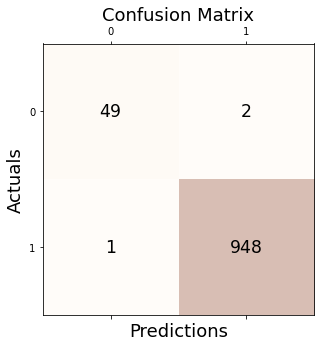

Accuracy: 0.997
Precision: 0.998
Recall: 0.999
F1 Score: 0.998


In [20]:
_conf.conf("GODE")

### LOF

In [21]:
np.random.seed(77)
clf = LocalOutlierFactor(contamination=0.05)

In [22]:
_conf = Conf_matrx(outlier_true_one_1,clf.fit_predict(_df))

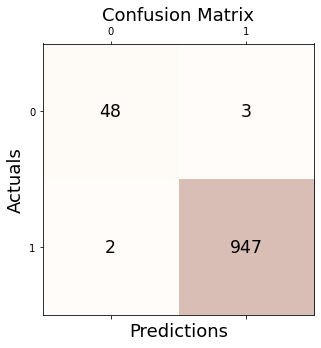

Accuracy: 0.995
Precision: 0.997
Recall: 0.998
F1 Score: 0.997


In [23]:
_conf.conf("LOF (Breunig et al., 2000)")

### KNN

In [24]:
from pyod.models.knn import KNN

In [25]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['knn_Clf'] = clf.labels_

In [26]:
outlier_KNN_one = list(clf.labels_)

In [27]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [28]:
_conf = Conf_matrx(outlier_true_one_1,outlier_KNN_one)

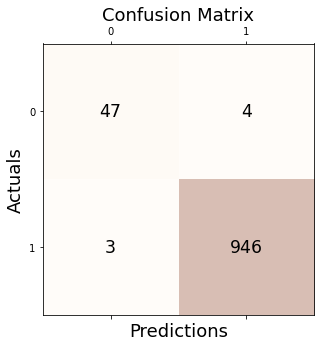

Accuracy: 0.993
Precision: 0.996
Recall: 0.997
F1 Score: 0.996


In [29]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

### CBLOF

In [30]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y']])
_df['CBLOF_Clf'] = clf.labels_

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

In [31]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y']])
_df['CBLOF_Clf'] = clf.labels_

outlier_CBLOF_one = list(clf.labels_)

outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

_conf = Conf_matrx(outlier_true_one_1,outlier_CBLOF_one)

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

AttributeError: 'NoneType' object has no attribute 'split'

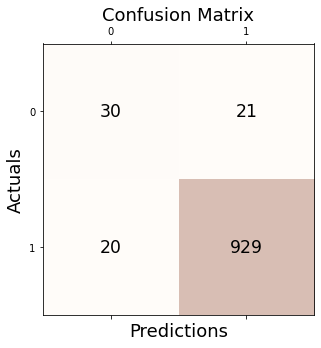

Accuracy: 0.959
Precision: 0.978
Recall: 0.979
F1 Score: 0.978


In [32]:
_conf.conf("CBLOF (He et al., 2003)")

### OCSVM

In [33]:
np.random.seed(77)
clf = svm.OneClassSVM(nu=0.05)

In [34]:
clf.fit(_df)

OneClassSVM(nu=0.05)

In [35]:
outlier_OSVM_one = list(clf.predict(_df))

In [36]:
_conf = Conf_matrx(outlier_true_one_1,outlier_OSVM_one)

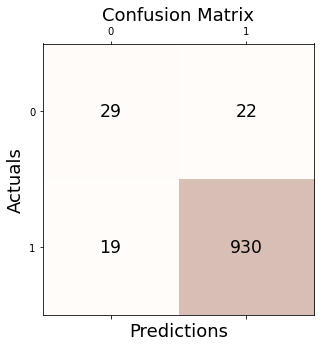

Accuracy: 0.959
Precision: 0.977
Recall: 0.980
F1 Score: 0.978


In [37]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

### MCD

In [38]:
clf = MCD(contamination=0.05, random_state = 77)
clf.fit(_df[['x', 'y']])
_df['MCD_clf'] = clf.labels_

In [39]:
outlier_MCD_one = list(clf.labels_)

In [40]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [41]:
_conf = Conf_matrx(outlier_true_one_1,outlier_MCD_one)

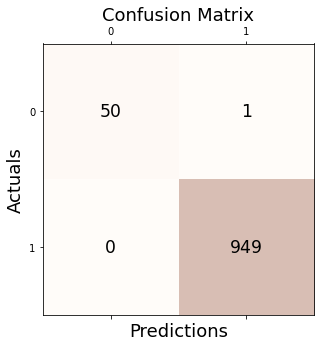

Accuracy: 0.999
Precision: 0.999
Recall: 1.000
F1 Score: 0.999


In [42]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

### Feature Bagging

In [43]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y']])
_df['FeatureBagging_clf'] = clf.labels_

In [44]:
outlier_FeatureBagging_one = list(clf.labels_)

In [45]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [46]:
_conf = Conf_matrx(outlier_true_one_1,outlier_FeatureBagging_one)

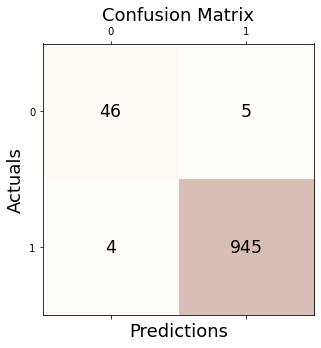

Accuracy: 0.991
Precision: 0.995
Recall: 0.996
F1 Score: 0.995


In [47]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

### ABOD

In [48]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = clf.labels_

In [49]:
outlier_ABOD_one = list(clf.labels_)

In [50]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [51]:
_conf = Conf_matrx(outlier_true_one_1,outlier_ABOD_one)

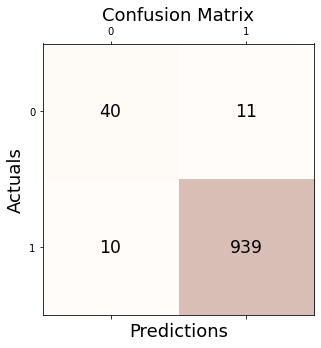

Accuracy: 0.979
Precision: 0.988
Recall: 0.989
F1 Score: 0.989


In [52]:
_conf.conf("ABOD (Kriegel et al., 2008)")

### IForest

In [53]:
np.random.seed(77)
od = IForest(
    threshold=0.
)

In [54]:
od.fit(_df[['x', 'y']])

In [55]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

In [56]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [57]:
outlier_alibi_one = _df['IF_alibi']

In [58]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [59]:
_conf = Conf_matrx(outlier_true_one_1,outlier_alibi_one)

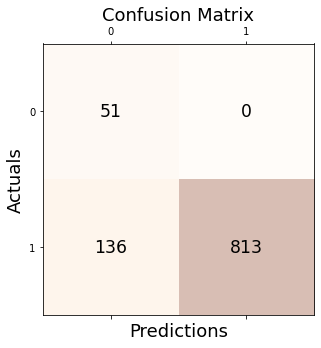

Accuracy: 0.864
Precision: 1.000
Recall: 0.857
F1 Score: 0.923


In [60]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

### HBOS

In [61]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['HBOS_clf'] = clf.labels_

In [62]:
outlier_HBOS_one = list(clf.labels_)

In [63]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [64]:
_conf = Conf_matrx(outlier_true_one_1,outlier_HBOS_one)

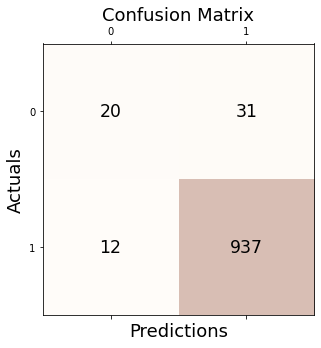

Accuracy: 0.957
Precision: 0.968
Recall: 0.987
F1 Score: 0.978


In [65]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

### SOS

In [66]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['SOS_clf'] = clf.labels_

In [67]:
outlier_SOS_one = list(clf.labels_)

In [68]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [69]:
_conf = Conf_matrx(outlier_true_one_1,outlier_SOS_one)

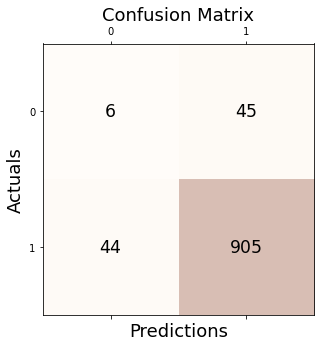

Accuracy: 0.911
Precision: 0.953
Recall: 0.954
F1 Score: 0.953


In [70]:
_conf.conf("SOS (Janssens et al., 2012)")

### SO_GAAL

In [71]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['SO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

In [72]:
outlier_SO_GAAL_one = list(clf.labels_)

In [73]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [74]:
_conf = Conf_matrx(outlier_true_one_1,outlier_SO_GAAL_one)

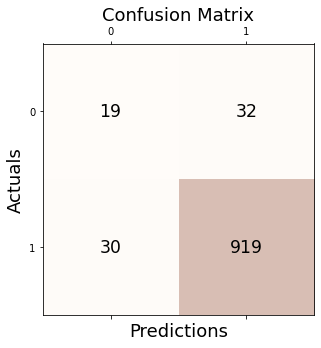

Accuracy: 0.938
Precision: 0.966
Recall: 0.968
F1 Score: 0.967


In [75]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

### MO_GAAL

In [ ]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 1 index 2:
32/32 [==============================] - 0s 3ms/step
Epoch 2 of 60

Testing for epoch 2 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 2 index 2:
32/32 [==============================] - 0s 3ms/step
Epoch 3 of 60

Testing for epoch 3 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 3 index 2:
32/32 [==============================] - 0s 2ms/step
Epoch 4 of 60

Testing for epoch 4 index 1:
32/32 [==============================] - 0s 3ms/step

Testing for epoch 4 index 2:
32/32 [==============================] - 0s 2ms/step
Epoch 5 of 60

Testing for epoch 5 index 1:
32/32 [==============================] - 0s 2ms/step

Testing for epoch 5 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 6 of 60

Testing for epoch 6 index 1:
32/32 [==============================] - 0s 3ms/step

Te

In [ ]:
outlier_MO_GAAL_one = list(clf.labels_)

In [ ]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_1,outlier_MO_GAAL_one)

In [ ]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

### LSCP

In [ ]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y']])
_df['LSCP_clf'] = clf.labels_

In [ ]:
outlier_LSCP_one = list(clf.labels_)

In [ ]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_1,outlier_LSCP_one)

In [ ]:
_conf.conf("LSCP (Zhao et al., 2019)")

## Orbit

In [ ]:
np.random.seed(3)
epsilon = np.around(np.random.normal(size=1000),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, 25).round(15), np.random.uniform(5, 7, 25).round(15), np.repeat(0, 950))), 1000)
eta = signal + epsilon

In [ ]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + eta

In [ ]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [ ]:
outlier_true_one = signal.copy()

In [ ]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

### GODE

In [ ]:
_Orbit = Orbit(_df)

In [ ]:
_Orbit.get_distance()

In [ ]:
_Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=2500) 

In [ ]:
_Orbit.fit(sd=15,ref=20)

In [ ]:
outlier_simul_one = (_Orbit.df['Residual']**2).tolist()

In [ ]:
outlier_simul_one = list(map(lambda x: -1 if x > 14 else 1,outlier_simul_one))

In [ ]:
outlier_simul_one.count(1)

In [ ]:
outlier_simul_one.count(-1)

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_simul_one)

In [ ]:
_conf.conf("GODE")

### LOF

In [ ]:
np.random.seed(77)
clf = LocalOutlierFactor(contamination=0.05)

In [ ]:
_conf = Conf_matrx(outlier_true_one,clf.fit_predict(_df))

In [ ]:
_conf.conf("LOF (Breunig et al., 2000)")

### KNN

In [ ]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['knn_clf'] = clf.labels_

In [ ]:
outlier_KNN_one = list(clf.labels_)

In [ ]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_KNN_one)

In [ ]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

### CBLOF

In [ ]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['CBLOF_Clf'] = clf.labels_

In [ ]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['CBLOF_Clf'] = clf.labels_

outlier_CBLOF_one = list(clf.labels_)

outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

_conf = Conf_matrx(outlier_true_one,outlier_CBLOF_one)

_conf.conf("CBLOF (He et al., 2003)")

### OCSVM

In [ ]:
np.random.seed(77)
clf = svm.OneClassSVM(nu=0.05)

In [ ]:
clf.fit(_df)

In [ ]:
outlier_OSVM_one = list(clf.predict(_df))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_OSVM_one)

In [ ]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

### MCD

In [ ]:
clf = MCD(contamination=0.05 , random_state = 77)
clf.fit(_df[['x', 'y','f']])
_df['MCD_clf'] = clf.labels_

In [ ]:
outlier_MCD_one = list(clf.labels_)

In [ ]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_MCD_one)

In [ ]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

### Feature Bagging

In [ ]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['FeatureBagging_clf'] = clf.labels_

In [ ]:
outlier_FeatureBagging_one = list(clf.labels_)

In [ ]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_FeatureBagging_one)

In [ ]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

### ABOD

In [ ]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['ABOD_Clf'] = clf.labels_

In [ ]:
outlier_ABOD_one = list(clf.labels_)

In [ ]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_ABOD_one)

In [ ]:
_conf.conf("ABOD (Kriegel et al., 2008)")

### IForest

In [ ]:
np.random.seed(77)
od = IForest(
    threshold=0.
)

In [ ]:
od.fit(_df[['x', 'y','f']])

In [ ]:
preds = od.predict(
    _df[['x', 'y','f']],
    return_instance_score=True
)

In [ ]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [ ]:
outlier_alibi_one = _df['IF_alibi']

In [ ]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_alibi_one)

In [ ]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

### HBOS

In [ ]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['HBOS_clf'] = clf.labels_

In [ ]:
outlier_HBOS_one = list(clf.labels_)

In [ ]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_HBOS_one)

In [ ]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

### SOS

In [ ]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['SOS_clf'] = clf.labels_

In [ ]:
outlier_SOS_one = list(clf.labels_)

In [ ]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_SOS_one)

In [ ]:
_conf.conf("SOS (Janssens et al., 2012)")

### SO_GAAL

In [ ]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['SO_GAAL_clf'] = clf.labels_

In [ ]:
outlier_SO_GAAL_one = list(clf.labels_)

In [ ]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_SO_GAAL_one)

In [ ]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

### MO_GAAL

In [ ]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['MO_GAAL_clf'] = clf.labels_

In [ ]:
outlier_MO_GAAL_one = list(clf.labels_)

In [ ]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_MO_GAAL_one)

In [ ]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

### LSCP

In [ ]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['LSCP_clf'] = clf.labels_

In [ ]:
outlier_LSCP_one = list(clf.labels_)

In [ ]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one,outlier_LSCP_one)

In [ ]:
_conf.conf("LSCP (Zhao et al., 2019)")

## Bunny

In [ ]:
G = graphs.Bunny()
n = G.N

In [ ]:
g = filters.Heat(G, tau=75) 

In [ ]:
n=2503

In [ ]:
np.random.seed(6)
normal = np.around(np.random.normal(size=n),15)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif

In [ ]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

In [ ]:
G.coords.shape

In [ ]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [ ]:
_df = pd.DataFrame({'x':_x,'y':_y,'z':_z})

In [ ]:
_df = {'W':_W,'x':_x,'y':_y,'z':_z, 'fnoise':f+noise,'f' : f, 'noise': noise,'unif':unif}

In [ ]:
_df = pd.DataFrame({'x': _df['x'],'y':_df['y'],'z':_df['z'],'fnoise':_df['fnoise'],'f':_df['f'],'noise':_df['noise']})

In [ ]:
unif = _df['unif']

In [ ]:
outlier_true_one_2 = unif.copy()

In [ ]:
outlier_true_one_2 = list(map(lambda x: -1 if x !=0  else 1,outlier_true_one_2))

In [ ]:
X = np.array(_df)[:,:4]

### GODE

In [ ]:
_W = _df['W']

In [ ]:
_BUNNY = BUNNY(_df)

In [ ]:
_BUNNY.fit(sd=20,ref=10)

In [ ]:
len(_BUNNY.f)

In [ ]:
2503*0.05

In [ ]:
outlier_simul_one = (_BUNNY.df['Residual']**2).tolist()

In [ ]:
outlier_simul_one = list(map(lambda x: -1 if x > 8.45 else 1,outlier_simul_one))

In [ ]:
outlier_simul_one.count(1)

In [ ]:
outlier_simul_one.count(-1)

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_simul_one)

In [ ]:
_conf.conf("GODE")

### LOF

In [ ]:
np.random.seed(77)
clf = LocalOutlierFactor(contamination=0.05)

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,clf.fit_predict(X))

In [ ]:
_conf.conf("LOF (Breunig et al., 2000)")

### KNN

In [ ]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['knn_Clf'] = clf.labels_

In [ ]:
outlier_KNN_one = list(clf.labels_)

In [ ]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_KNN_one)

In [ ]:
_conf.conf("kNN (Ramaswamy et al., 2000)")

### CBLOF

In [ ]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])
_df['CBLOF_Clf'] = clf.labels_

In [ ]:
outlier_CBLOF_one = list(clf.labels_)

In [ ]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_CBLOF_one)

In [ ]:
_conf.conf("CBLOF (He et al., 2003)")

### OCSVM

In [ ]:
np.random.seed(77)
clf = svm.OneClassSVM(nu=0.05)

In [ ]:
clf.fit(X)

In [ ]:
outlier_OSVM_one = list(clf.predict(X))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_OSVM_one)

In [ ]:
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

### MCD

In [ ]:
clf = MCD(contamination=0.05 , random_state = 77)
clf.fit(_df[['x', 'y','fnoise']])
_df['MCD_clf'] = clf.labels_

In [ ]:
outlier_MCD_one = list(clf.labels_)

In [ ]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_MCD_one)

In [ ]:
_conf.conf("MCD (Hardin and Rocke, 2004)")

### Feature Bagging

In [ ]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])
_df['FeatureBagging_clf'] = clf.labels_

In [ ]:
outlier_FeatureBagging_one = list(clf.labels_)

In [ ]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_FeatureBagging_one)

In [ ]:
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

### ABOD

In [ ]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['ABOD_Clf'] = clf.labels_

In [ ]:
outlier_ABOD_one = list(clf.labels_)

In [ ]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_ABOD_one)

In [ ]:
_conf.conf("ABOD (Kriegel et al., 2008)")

### IForest

In [ ]:
np.random.seed(77)
od = IForest(
    threshold=0.
)

In [ ]:
od.fit(_df[['x', 'y','fnoise']])

In [ ]:
preds = od.predict(
    _df[['x', 'y','fnoise']],
    return_instance_score=True
)

In [ ]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [ ]:
outlier_alibi_one = _df['IF_alibi']

In [ ]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_alibi_one)

In [ ]:
_conf.conf("Isolation Forest (Liu et al., 2008)")

### HBOS

In [ ]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['HBOS_clf'] = clf.labels_

In [ ]:
outlier_HBOS_one = list(clf.labels_)

In [ ]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_HBOS_one)

In [ ]:
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

### SOS

In [ ]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['SOS_clf'] = clf.labels_

In [ ]:
outlier_SOS_one = list(clf.labels_)

In [ ]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_SOS_one)

In [ ]:
_conf.conf("SOS (Janssens et al., 2012)")

### SO_GAAL

In [ ]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['SO_GAAL_clf'] = clf.labels_

In [ ]:
outlier_SO_GAAL_one = list(clf.labels_)

In [ ]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_SO_GAAL_one)

In [ ]:
_conf.conf("SO-GAAL (Liu et al., 2019)")

### MO_GAAL

In [ ]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['MO_GAAL_clf'] = clf.labels_

In [ ]:
outlier_MO_GAAL_one = list(clf.labels_)

In [ ]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_MO_GAAL_one)

In [ ]:
_conf.conf("MO-GAAL (Liu et al., 2019)")

### LSCP

In [ ]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])
_df['LSCP_clf'] = clf.labels_

In [ ]:
outlier_LSCP_one = list(clf.labels_)

In [ ]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [ ]:
_conf = Conf_matrx(outlier_true_one_2,outlier_LSCP_one)

In [ ]:
_conf.conf("LSCP (Zhao et al., 2019)")